CNN-LSTM architecture for Image Caption generation on COCO 2014 dataset

In [2]:
# imports
from collections import Counter
import os
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.transforms as transforms
import nltk
from pycocotools.coco import COCO
import torch.utils.data as data
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from tqdm import tqdm
from custom_coco_dataset import CustomCocoDataset, collate_function, get_loader
from vocab_wrapper import Vocab

# tokenizer model
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pepijnschouten/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Text preprocessing - Build the VOCAB

In [ ]:
# Build vocabulary (words to numeric tokens)
def build_vocabulary(json, threshold):
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.word_tokenize(caption.lower())
        counter.update(tokens)
        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))
    # If the word frequency is less than 'threshold', then the word is discarded.
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]
    # create a vocab wrapper + add special token
    vocab = Vocab()
    vocab.add_token("<pad>")
    vocab.add_token("<start>")
    vocab.add_token("<end>")
    vocab.add_token("<unk>")
    # add words to vocab
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab
            

vocab = build_vocabulary(json='Datasets/COCO_IMAGE_CAPTION_JPG_JSON/annotations_train_val/' \
                                'captions_train2014.json', threshold=4)
counter = Counter()  # Count the frequency of each word
vocab_path = os.path.join('vocabulary', 'vocabulary.pkl')
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
tokens = nltk.word_tokenize(caption.lower())  # Tokenize the caption
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))


Image preprocessing - Resize images

In [ ]:
def resize_image(image, shape):
    return image.resize(shape, Image.LANCZOS)

def resize_images(image_path, output_path, shape):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    images = os.listdir(image_path)
    num_im = len(images)
    for i, im in enumerate(images):
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                image = resize_image(image, shape)
                image.save(os.path.join(output_path, im), image.format)
        if (i+1) % 1000 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_im, output_path))

image_path = 'Datasets/COCO_IMAGE_CAPTION_JPG_JSON/train2014'
output_path = 'train_data'
shape = [256, 256]
resize_images(image_path, output_path, shape)

Create the custom datalader compatible with torch.utils.data.Dataloader

Define the DL model
- CNN MODEL
    - RESNET 152
        - LAST FCL trainable\[1000->256\] 
        - batch norm insulates against data shifts
    - LSTM model
        - input: embedding vectors
        - output: sequence of words
        - uses greedy search

In [9]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        # load the pretrained ResNet-152 and replace top fc layer
        super(CNNModel, self).__init__()
        resnet = models.resnet152(
            weights=models.resnet.ResNet152_Weights.DEFAULT
        )
        module_list = list(resnet.children())[:-1] # delete last layer
        self.resnet_module = nn.Sequential(*module_list)
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)
        
    def forward(self, input_images):
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)
        resnet_features = resnet_features.reshape(
            resnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(resnet_features))

        return final_features
        
        
class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size,
                 vocabulary_size, num_layers, max_seq_len=20):
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size,
                                  num_layers=num_layers,
                                  batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len
        
    def forward(self, input_features, capts, lens):
        embeddings = self.embedding_layer(caps)
        embeddings = torch.cat((input_features.unsqueeze(1),
                                embeddings), dim=1)
        lstm_input = pack_padded_sequence(
            embeddings, lens, batch_first=True)
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        
        return model_outputs
        
    def sample(self, input_features, lstm_states=None):
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(
                lstm_inputs, lstm_states)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))
            _, predicted_outputs = model_outputs.max(1)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)
            lstm_inputs = lstm_inputs.unsqueeze(1)
        sampled_indices = torch.stack(sampled_indices, 1)
        
        return sampled_indices

Create a training loop

In [ ]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
# device = torch.device('cpu')

if not os.path.exists("models_dir"):
    os.makedirs("models_dir")
    
# image transformations
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


# load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocabulary = pickle.load(f)
    
coco_json_path = 'Datasets/COCO_IMAGE_CAPTION_JPG_JSON/annotations_train_val/' \
                    'captions_train2014.json'    

#  build dataloader
custom_data_loader = get_loader(
    data_path=output_path,
    coco_json_path=coco_json_path,
    vocabulary=vocabulary,
    transform=transform,
    batch_size=128,
    shuffle=True,
    num_workers=2)

#  build the model
encoder_model = CNNModel(embedding_size=256).to(device)
decoder_model = LSTMModel(embedding_size=256,
                          hidden_layer_size=512,
                          vocabulary_size=len(vocabulary),
                          num_layers=1).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + \
    list(encoder_model.linear_layer.parameters())
optimizer = torch.optim.Adam(parameters, lr=1e-3)

# number of epochts
epochs = 5

# train the model
total_num_steps = len(custom_data_loader)
print("start model training")
for epoch in range(epochs):
    for i, (imgs, caps, lens) in enumerate(custom_data_loader):

        # set minibatch dataset
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]
        
        # Forward, backward and optimize
        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = criterion(outputs, tgts)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print log info
        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 5, i, total_num_steps, loss.item(), np.exp(loss.item()))) 
 
        # Save the model checkpoints
        if (i+1) % 1000 == 0:
            torch.save(decoder_model.state_dict(), os.path.join("models_dir", 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder_model.state_dict(), os.path.join("models_dir", 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))


Predict captions to images

<start> a dog is standing on a wooden bench . <end>


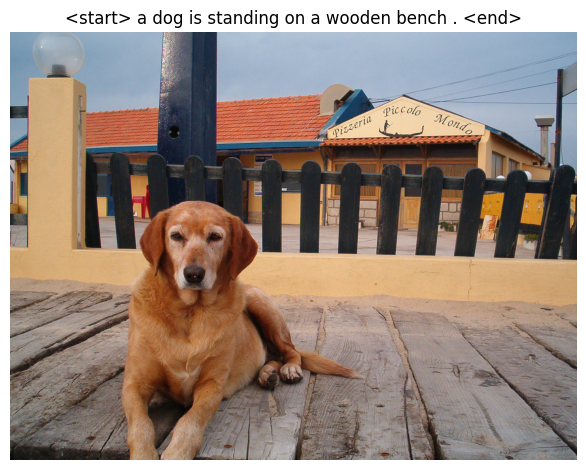

In [12]:
image_file_path = 'sample_image/sample.jpg'
        
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize((256, 256), Image.LANCZOS)
    
    if transform is not None:
        img = transform(img).unsqueeze(0)
    
    return img

# image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
vocab_path = os.path.join('vocabulary', 'vocabulary.pkl')
with open(vocab_path, 'rb') as f:
    vocabulary = pickle.load(f)

# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)

# load the trained model parameters
encoder_weight_path = "models_dir/encoder-2-2000.ckpt"

decoder_weight_path = "models_dir/decoder-2-2000.ckpt"

encoder_model.load_state_dict(torch.load(encoder_weight_path,
                                         weights_only=True))
decoder_model.load_state_dict(torch.load(decoder_weight_path,
                                         weights_only=True))

# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)


# Generate an caption from the image
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()  # (1, max_seq_length) -> (max_seq_length)


# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)


# Print out the image and the generated caption
print (predicted_sentence)
img = Image.open(image_file_path)
plt.figure(dpi=100, tight_layout=True)
plt.imshow(np.asarray(img))
plt.title(predicted_sentence)
plt.axis('off')
plt.show()
    